In [12]:
import pandas as pd
import numpy as np

In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset")

df = pd.read_csv(path + '/Titanic-Dataset.csv')
df

100%|██████████| 22.0k/22.0k [00:00<00:00, 298kB/s]

Extracting model files...


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [14]:
processed_df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
processed_df


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [15]:
processed_df['Sex'], sex_codes = pd.factorize(processed_df['Sex'])
processed_df['Embarked'], embarked_codes = pd.factorize(processed_df['Embarked'])
processed_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0
887,1,1,1,19.0,0,0,30.0000,0
888,0,3,1,NaN,1,2,23.4500,0
889,1,1,0,26.0,0,0,30.0000,1


In [5]:
y = processed_df['Survived'].to_numpy()
X = processed_df.drop(['Survived'], axis=1)
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0
887,1,1,19.0,0,0,30.0000,0
888,3,1,NaN,1,2,23.4500,0
889,1,0,26.0,0,0,30.0000,1


In [16]:
from sklearn.model_selection import train_test_split
from numpy import signedinteger, ndarray
from dataclasses import dataclass
from typing import Self, Callable, Literal
from enum import IntEnum
import numpy.typing as npt


class FeatureType(IntEnum):
    CATEGORY = 0
    CONTINUOUS = 1


@dataclass(slots=True, frozen=True)
class Predicate:
    name: str
    value: int | float
    feature_type: FeatureType


@dataclass
class LeafNode:
    parent: "InnerNode"
    value: signedinteger | np.float_


@dataclass
class InnerNode:
    parent: Self
    predicate: Predicate
    children: list[LeafNode | Self]

    @property
    def right_child(self):
        return self.children[-1]

    @property
    def left_child(self):
        return self.children[0]


def apply_predicate_plural(x: pd.DataFrame, predicate: Predicate) -> npt.NDArray[np.bool_]:
    if predicate.feature_type == FeatureType.CATEGORY:
        return np.where(x[predicate.name].values == predicate.value)[0]
    elif predicate.feature_type == FeatureType.CONTINUOUS:
        return np.where(x[predicate.name].values >= predicate.value)[0]


def apply_predicate_singular(x: pd.Series, predicate: Predicate) -> bool:
    if predicate.feature_type == FeatureType.CATEGORY:
        return x[predicate.name] == predicate.value
    elif predicate.feature_type == FeatureType.CONTINUOUS:
        return x[predicate.name] >= predicate.value


def _uncertainty_measure_criterion(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    _, counts = np.unique(y, return_counts=True)
    class_probabilities = counts / len(y)
    return class_probabilities


CriterionT = Callable[[np.ndarray], float]


def entropy(y: np.ndarray) -> float:
    class_probabilities = _uncertainty_measure_criterion(y)
    return - np.sum(class_probabilities * np.log2(class_probabilities + 1e-6))


def gini(y: np.ndarray) -> float:
    class_probabilities = _uncertainty_measure_criterion(y)
    return np.sum(class_probabilities * (1 - class_probabilities))


def donskoy(y: np.ndarray) -> float:
    class_probabilities = _uncertainty_measure_criterion(y)
    return np.sum(class_probabilities * (class_probabilities - 1))


def mse(y: np.ndarray) -> float:
    return np.mean(y ** 2)


def information_gain(
        x: pd.DataFrame,
        y: np.ndarray,
        predicate: Predicate,
        criterion: CriterionT,
) -> float:
    uncertainty_measure = criterion(y)

    right_leaf_indices = apply_predicate_plural(x, predicate)
    left_leaf_indices = np.setdiff1d(np.arange(len(y)), right_leaf_indices)

    left_leaf, right_leaf = y[left_leaf_indices], y[right_leaf_indices]
    left_uncertainty, right_uncertainty = criterion(left_leaf), criterion(right_leaf)

    return uncertainty_measure - (
            + left_uncertainty * len(left_leaf) / len(y)
            + right_uncertainty * len(right_leaf) / len(y)
    )


def information_gain2(x: pd.DataFrame, y: np.ndarray, predicate: Predicate) -> float:
    uncertainty_measure = entropy(y)
    right_leaf_indices = apply_predicate_plural(x, predicate)
    left_leaf_indices = np.setdiff1d(np.arange(len(y)), right_leaf_indices)
    left_leaf, right_leaf = y[left_leaf_indices], y[right_leaf_indices]
    return uncertainty_measure - (
            + entropy(left_leaf) * len(left_leaf) / len(y)
            + entropy(right_leaf) * len(right_leaf) / len(y)
    )


def predict(id3_root: LeafNode | InnerNode, x: pd.Series) -> signedinteger | np.float_:
    node = id3_root
    while isinstance(node, InnerNode):
        if apply_predicate_singular(x, node.predicate):
            node = node.right_child
        else:
            node = node.left_child
    return node.klass


def predict_bulk(id3_root: LeafNode | InnerNode, x: pd.DataFrame) -> ndarray:
    return np.array([predict(id3_root, sample) for _, sample in x.iterrows()])


class I3:
    root: LeafNode | InnerNode | None
    criterion: CriterionT
    feature_type: FeatureType

    def __init__(
            self,
            criterion: CriterionT,
            feature_type: FeatureType,
            feature_type_map: dict[Literal['Survived'], FeatureType]
    ):
        self.criterion = criterion
        self.root = None
        self.feature_type = feature_type
        self.feature_type_map = feature_type_map

    def _build_i3_recursive(
            self,
            parent: InnerNode | None,
            x: pd.DataFrame,
            y: np.ndarray,
    ) -> LeafNode | InnerNode:
        if (
                np.unique(y).size > 1
                and
                (relevant_predicates := [
                    Predicate(name=column, value=unique_value, feature_type=self.feature_type_map[column])
                    for column in x.columns if len(unique_values := x[column].dropna().unique()) > 1
                    for unique_value in unique_values
                ])
        ):
            best_predicate = relevant_predicates[
                np.argmax(
                    [
                        information_gain(x, y, predicate, self.criterion)
                        for predicate in relevant_predicates
                    ]
                )
            ]
            right_leaf_indices = apply_predicate_plural(x, best_predicate)
            left_leaf_indices = np.setdiff1d(np.arange(len(y)), right_leaf_indices)
            if left_leaf_indices.size and right_leaf_indices.size:
                new_inner_node = InnerNode(
                    parent=parent,
                    predicate=best_predicate,
                    children=[],
                )
                perspective_left_leaf, perspective_right_leaf = y[left_leaf_indices], y[right_leaf_indices]

                new_inner_node.children = [
                    self._build_i3_recursive(new_inner_node, x.iloc[left_leaf_indices], perspective_left_leaf),
                    self._build_i3_recursive(new_inner_node, x.iloc[right_leaf_indices], perspective_right_leaf),
                ]
                return new_inner_node

        return LeafNode(
            parent=parent,
            value=self._node_value(y),
        )

    def fit(self, x: pd.DataFrame, y: np.ndarray):
        self.root = self._build_i3_recursive(None, x, y)

    def _predict(self, node: LeafNode | InnerNode, x: pd.Series) -> signedinteger | np.float_:
        while isinstance(node, InnerNode):
            if apply_predicate_singular(x, node.predicate):
                node = node.right_child
            else:
                node = node.left_child
        return node.value

    def predict(self, x: pd.Series) -> ndarray:
        return self._predict(self.root, x)

    def predict_bulk(self, x: pd.DataFrame) -> ndarray:
        return self._predict_bulk(self.root, x)

    def _predict_bulk(self, node: LeafNode | InnerNode, x: pd.DataFrame) -> ndarray:
        return np.array([self._predict(node, sample) for _, sample in x.iterrows()])

    def _node_value(self, y: np.ndarray) -> signedinteger | np.float_:
        if self.feature_type is FeatureType.CATEGORY:
            return np.argmax(np.bincount(y))
        else:
            if len(y) == 0:
                raise Exception("Empty leaf")
            return np.mean(y)

    def _post_pruning_recursive(self, node: LeafNode | InnerNode, X_ctrl: pd.DataFrame, y_ctrl: np.ndarray) -> None:
        if isinstance(node, LeafNode):
            return
        right_leaf_indices = apply_predicate_plural(X_ctrl, node.predicate)
        left_leaf_indices = np.setdiff1d(np.arange(len(y_ctrl)), right_leaf_indices)
        if not left_leaf_indices.size:
            node.children[0] = LeafNode(
                parent=node,
                value=self._node_value(y_ctrl),
            )

        if not right_leaf_indices.size:
            node.children[1] = LeafNode(
                parent=node,
                value=self._node_value(y_ctrl),
            )
        self._post_pruning_recursive(node.left_child, X_ctrl.iloc[left_leaf_indices], y_ctrl[left_leaf_indices])
        self._post_pruning_recursive(node.right_child, X_ctrl.iloc[right_leaf_indices], y_ctrl[right_leaf_indices])
        if (parent := node.parent) is None:
            return

        error_count_parent = np.sum(y_ctrl != self._predict_bulk(node, X_ctrl))
        error_count_left = np.sum(y_ctrl != self._predict_bulk(node.left_child, X_ctrl))
        error_count_right = np.sum(y_ctrl != self._predict_bulk(node.right_child, X_ctrl))

        values = np.unique(y_ctrl)
        if self.feature_type is FeatureType.CATEGORY:
            error_counts_just_value = [np.sum(y_ctrl != value) for value in values]
        else:
            error_counts_just_value = [mse(value - y_ctrl) for value in values]

        NODE_ERROR_IDX, LEFT_CHILD_ERROR_IDX, RIGHT_CHILD_ERROR_IDX, *UNIVERSAL_VALUE_ERROR_IDS = \
            list(range(3 + len(np.unique(y_ctrl))))

        errors = [error_count_parent, error_count_left, error_count_right, *error_counts_just_value]
        # because when errors count are equals, we should prefer to reduce tree complexity

        argmin_index = len(errors) - 1 - np.argmin(errors[::-1])

        if argmin_index != NODE_ERROR_IDX:
            child_idx = [child is node for child in parent.children].index(True)

        if argmin_index == LEFT_CHILD_ERROR_IDX:
            left_child = node.left_child
            parent.children[child_idx] = left_child
            left_child.parent = parent
        elif argmin_index == RIGHT_CHILD_ERROR_IDX:
            right_child = node.right_child
            parent.children[child_idx] = right_child
            right_child.parent = parent
        elif argmin_index in UNIVERSAL_VALUE_ERROR_IDS:
            parent.children[child_idx] = LeafNode(
                parent=parent,
                value=values[argmin_index - len([NODE_ERROR_IDX, LEFT_CHILD_ERROR_IDX, RIGHT_CHILD_ERROR_IDX])],
            )

    def post_pruning(
            self,
            X_ctrl: pd.DataFrame,
            y_ctrl: np.ndarray
    ) -> LeafNode | InnerNode:
        self._post_pruning_recursive(self.root, X_ctrl, y_ctrl)
        return self.root



In [17]:
processed_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,0
887,1,1,1,19.0,0,0,30.0000,0
888,0,3,1,NaN,1,2,23.4500,0
889,1,1,0,26.0,0,0,30.0000,1


In [18]:
y = processed_df['Fare'].to_numpy()
X = processed_df.drop(['Fare'], axis=1)
X

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22.0,1,0,0
1,1,1,1,38.0,1,0,1
2,1,3,1,26.0,0,0,0
3,1,1,1,35.0,1,0,0
4,0,3,0,35.0,0,0,0
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,0
887,1,1,1,19.0,0,0,0
888,0,3,1,NaN,1,2,0
889,1,1,0,26.0,0,0,1


In [48]:
from sklearn.tree._criterion import MSE
from sklearn.metrics import accuracy_score, classification_report

feature_type_map = {
    'Pclass': FeatureType.CATEGORY,
    'Sex': FeatureType.CATEGORY,
    'Age': FeatureType.CONTINUOUS,
    'SibSp': FeatureType.CONTINUOUS,
    'Parch': FeatureType.CONTINUOUS,
    'Fare': FeatureType.CONTINUOUS,
    'Embarked': FeatureType.CATEGORY,
    'Survived': FeatureType.CATEGORY,
}
y = processed_df['Fare'].to_numpy()
X = processed_df.drop(['Fare'], axis=1)

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train, X_ctrl, y_train, y_ctrl = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
i3 = I3(criterion=mse, feature_type=FeatureType.CONTINUOUS, feature_type_map=feature_type_map)
i3.fit(X_train, y_train)
print(mse(y_test - i3.predict_bulk(X_test)))
# print(mse(y_test - i3.predict_bulk(X_test)))
# print(mse(y_ctrl - i3.predict_bulk(X_ctrl)))
# for i, j in zip(y_test[:5], i3.predict_bulk(X_test.iloc[:5])):
#     print(f'{j} ~ {i}')
i3.post_pruning(X_ctrl, y_ctrl)
pruned_i3 = i3
# print(mse(y_test - i3.predict_bulk(X_test)))
# print(mse(y_ctrl - i3.predict_bulk(X_ctrl)))

i3 = I3(criterion=mse, feature_type=FeatureType.CONTINUOUS, feature_type_map=feature_type_map)
i3.fit(X_train, y_train)

print(mse(y_test - pruned_i3.predict_bulk(X_test)))

2237.6387669497626
2382.0964417661194


In [49]:
from graphviz import Digraph


def get_id(node: InnerNode | LeafNode) -> str:
    return str(id(node))


def transform_recursively(
        node: InnerNode | LeafNode,
        graph: Digraph,
        parent_id: str,
        added_edges: set[str],
        visited_nodes: set[str]
) -> Digraph:
    if (current_node_id := get_id(node)) not in visited_nodes:
        if isinstance(node, LeafNode):
            graph.node(current_node_id, label=f"Leaf [value={node.value}]")
        elif isinstance(node, InnerNode):
            graph.node(current_node_id, label=f"Inner [{node.predicate.name} = {node.predicate.value}]")
            visited_nodes.add(current_node_id)
            for child in node.children:
                graph = transform_recursively(child, graph, current_node_id, added_edges, visited_nodes)

    if parent_id and (edge := (parent_id, current_node_id)) not in added_edges:

        if is_left_child := current_node_id == get_id(node.parent.children[0]):
            if node.parent.predicate.feature_type == FeatureType.CATEGORY:
                operator = "="
            else:
                operator = "<"
        else:  # is_right_child
            if node.parent.predicate.feature_type == FeatureType.CATEGORY:
                operator = "<>"
            else:
                operator = ">="
        graph.edge(*edge, label=f"{node.parent.predicate.name} {operator} {node.parent.predicate.value}")
        added_edges.add(edge)

    return graph


def transform_to_digraph(node, parent_name=None, ) -> Digraph:
    graph = Digraph(comment="Tree Structure")
    graph.attr(cluster='true')
    added_edges = set()
    visited_nodes = set()

    return transform_recursively(node, graph, parent_name, added_edges, visited_nodes)


original_tree = transform_to_digraph(i3.root)
post_pruned_tree = transform_to_digraph(pruned_i3.root)

trees = Digraph()
trees.attr(rankdir='LR', nodesep='0.25', ranksep='1.0', splines='false', overlap='false')

trees.subgraph(original_tree)
trees.subgraph(post_pruned_tree)

trees.render('pruned_tree', format='png', view=True, cleanup=True)

'pruned_tree.png'

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       168
           1       0.72      0.63      0.67       100

    accuracy                           0.77       268
   macro avg       0.76      0.74      0.75       268
weighted avg       0.77      0.77      0.77       268



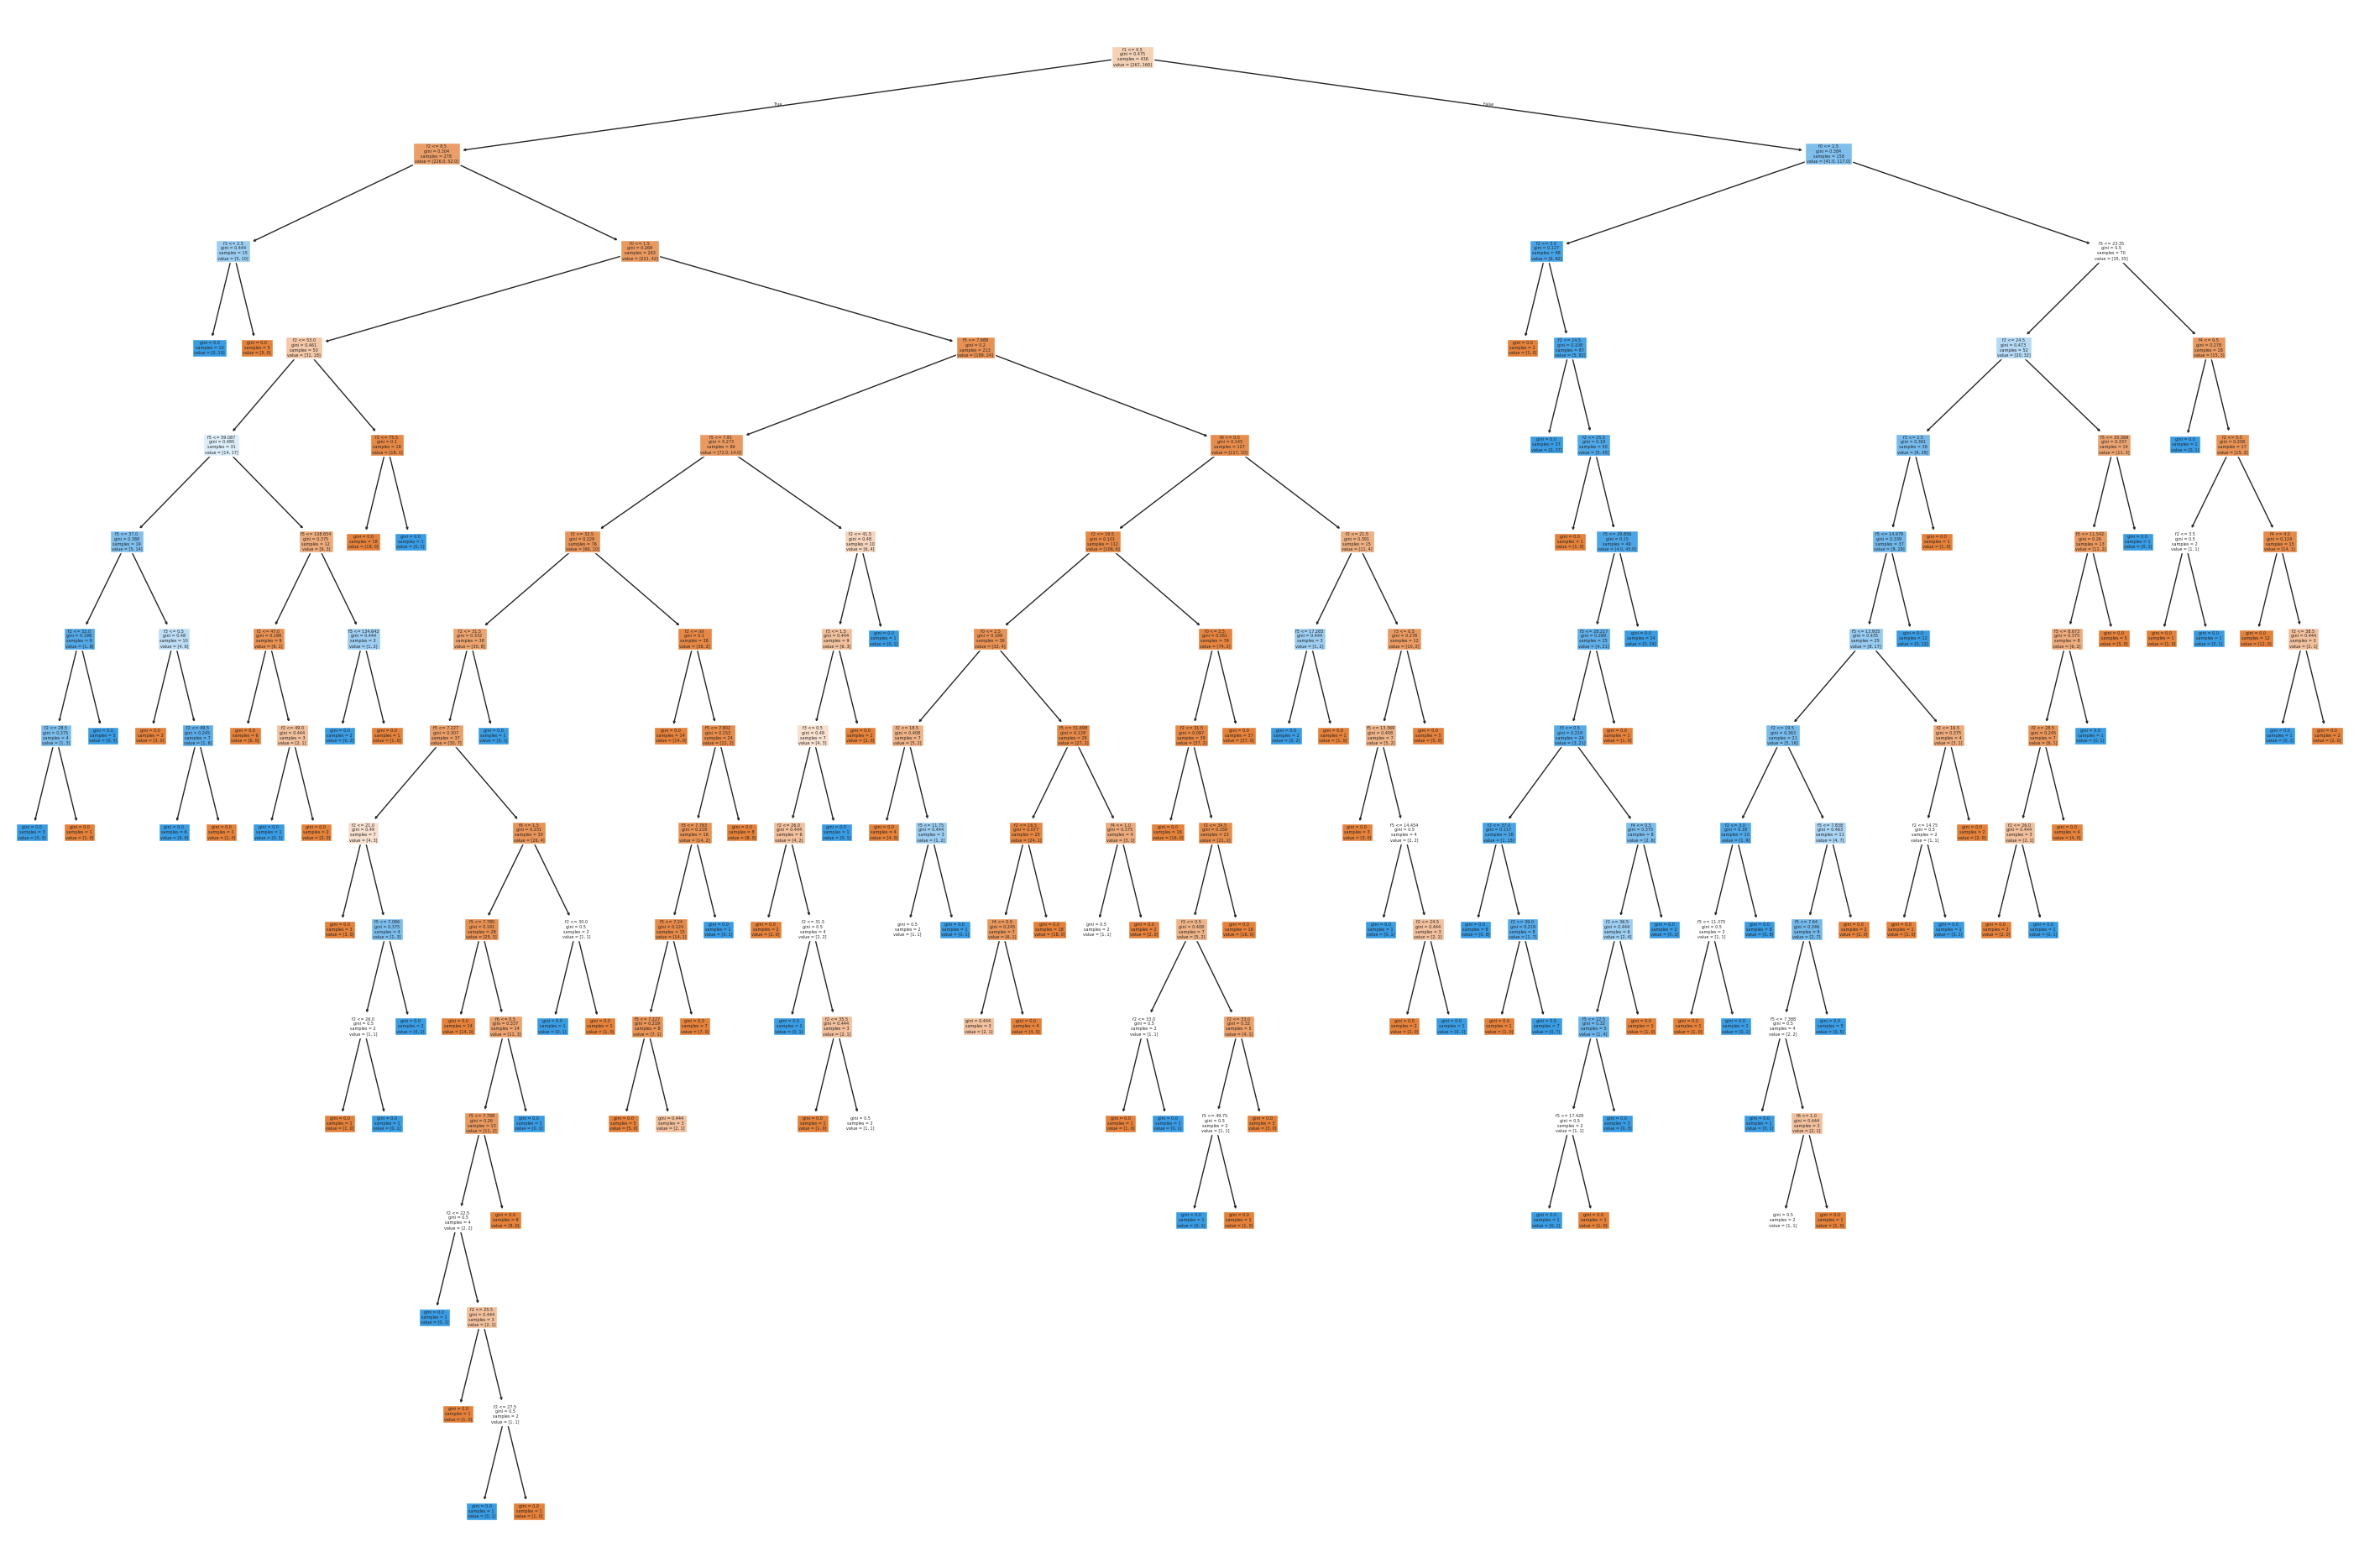

In [38]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(random_state=0, criterion='gini')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(36, 24))
plot_tree(clf, filled=True, feature_names=[f"f{i}" for i in range(X_train.shape[1])])
plt.show()


In [39]:
%timeit clf.fit(X_train, y_train)

1.21 ms ± 52.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Accuracy: 0.7761194029850746


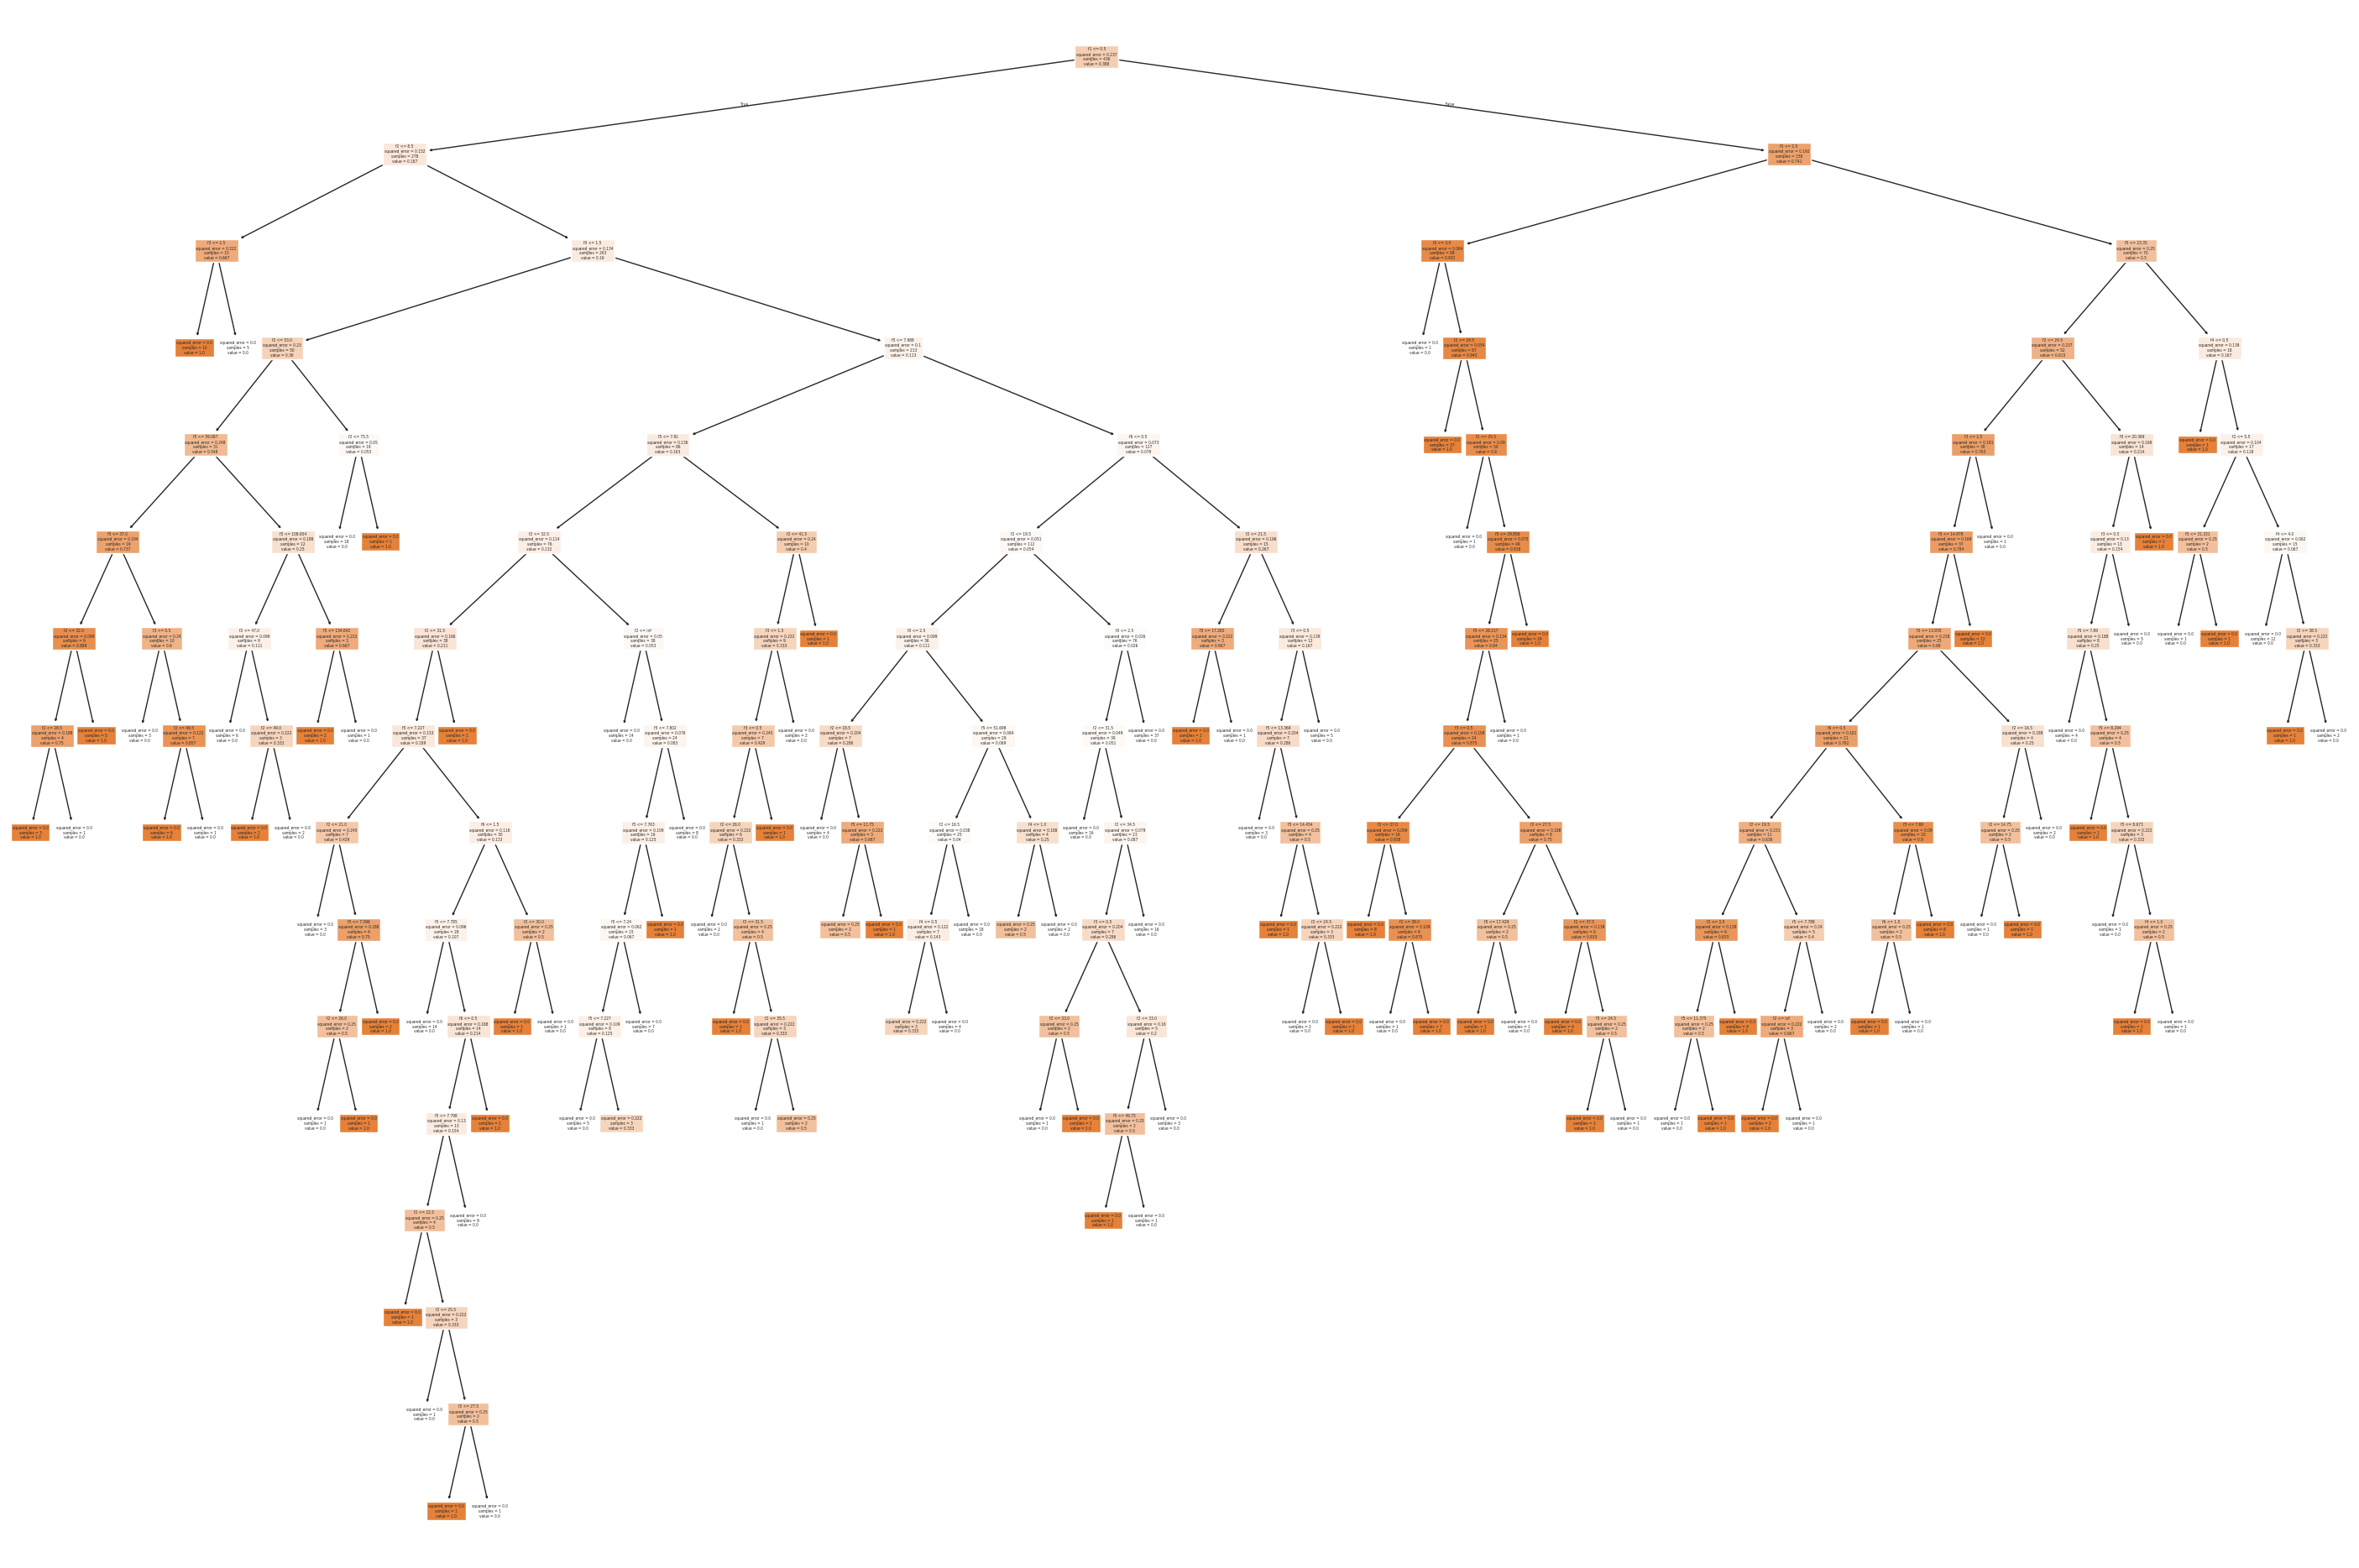

In [32]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

clf = DecisionTreeRegressor(random_state=0, criterion='squared_error')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

plt.figure(figsize=(36, 24))
plot_tree(clf, filled=True, feature_names=[f"f{i}" for i in range(X_train.shape[1])])
plt.show()


In [40]:
i3 = I3(criterion=donskoy, feature_type=FeatureType.CATEGORY, feature_type_map=feature_type_map)
i3.fit(X_train, y_train)
print(classification_report(y_test, i3.predict_bulk(X_test)))
# print(mse(y_test - i3.predict_bulk(X_test)))
# print(mse(y_ctrl - i3.predict_bulk(X_ctrl)))
# for i, j in zip(y_test[:5], i3.predict_bulk(X_test.iloc[:5])):
#     print(f'{j} ~ {i}')
i3.post_pruning(X_ctrl, y_ctrl)

%timeit i3.fit(X_train, y_train);i3.post_pruning(X_ctrl, y_ctrl)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       168
           1       0.70      0.64      0.67       100

    accuracy                           0.76       268
   macro avg       0.75      0.74      0.74       268
weighted avg       0.76      0.76      0.76       268

385 ms ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
